<a href="https://colab.research.google.com/github/xmpuspus/Lectures/blob/master/notebooks/PHEarthquakePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
# !pip install geopandas
# import geopandas as gpd
# from shapely.geometry import Point, Polygon

In [0]:
df_list = []
df = pd.read_html("http://earthquake.phivolcs.dost.gov.ph/")[1][1:]
df.columns = df.iloc[0]
df.drop(1, inplace=True)
df_list.append(df)
df.head()

1,Date - Time (Philippine Time),Latitude (ºN),Longitude (ºE),Depth (km),Mag,Location
2,23 April 2019 - 07:45 PM,07.54,126.22,024,2.3,016 km S 59° E of New Bataan (Compostela Valley)
3,23 April 2019 - 07:31 PM,11.78,125.19,023,2.4,015 km N 58° E of Hinabangan (Western Samar)
4,23 April 2019 - 07:22 PM,11.79,125.20,022,2.8,017 km N 56° E of Hinabangan (Western Samar)
5,23 April 2019 - 07:11 PM,07.78,126.40,146,3.3,006 km S 75° W of Cateel (Davao Oriental)
6,23 April 2019 - 07:11 PM,15.05,120.34,032,1.8,020 km N 50° E of Castillejos (Zambales)


In [0]:
months = ['January', 'February', "March"]
for i in months:
    df_temp = pd.read_html(f"http://earthquake.phivolcs.dost.gov.ph/EQLatest-Monthly/2019/2019_{i}.html")[1][1:]
    df_temp.columns = df_temp.iloc[0]
    df_temp.drop(1, inplace=True)
    df_list.append(df_temp)

In [0]:
df_all = pd.concat(df_list)

In [0]:
import time

In [0]:
# Data cleaning
df_all['dates'] = pd.to_datetime(df_all['Date - Time  (Philippine Time)'])

df_all['longitude'] = df_all['Longitude  (ºE)'].str.replace("`", '').astype(float)

df_all['latitude'] = df_all['Latitude  (ºN)'].str.replace("`", '').astype(float)

df_all['Mag'] = pd.to_numeric(df_all['Mag'], errors='coerce')

df_all['depth'] = df_all['Depth  (km)'].astype(float)

df_all.dropna(inplace=True)

In [0]:
df_all['time'] = df_all['dates'].apply(lambda ts: time.mktime(ts.timetuple()))

In [0]:
df_all.head()

1,Date - Time (Philippine Time),Latitude (ºN),Longitude (ºE),Depth (km),Mag,Location,dates,longitude,latitude,depth,time
2,23 April 2019 - 07:45 PM,07.54,126.22,024,2.3,016 km S 59° E of New Bataan (Compostela Valley),2019-04-23 19:45:00,126.22,7.54,24.0,1.556049e+09
3,23 April 2019 - 07:31 PM,11.78,125.19,023,2.4,015 km N 58° E of Hinabangan (Western Samar),2019-04-23 19:31:00,125.19,11.78,23.0,1.556048e+09
4,23 April 2019 - 07:22 PM,11.79,125.20,022,2.8,017 km N 56° E of Hinabangan (Western Samar),2019-04-23 19:22:00,125.20,11.79,22.0,1.556047e+09
5,23 April 2019 - 07:11 PM,07.78,126.40,146,3.3,006 km S 75° W of Cateel (Davao Oriental),2019-04-23 19:11:00,126.40,7.78,146.0,1.556047e+09
6,23 April 2019 - 07:11 PM,15.05,120.34,032,1.8,020 km N 50° E of Castillejos (Zambales),2019-04-23 19:11:00,120.34,15.05,32.0,1.556047e+09


In [0]:
!pip install -U pyarrow
df_all.to_parquet('ph_earthquake_data.parquet')

    100% |████████████████████████████████| 48.5MB 779kB/s 


In [0]:
X = df_all[['latitude', 'longitude']]
y = df_all['Mag']

In [0]:
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = X[:2000], X[2000:], y[:2000], y[2000:]
print(X_train.shape, X_test.shape, y_train.shape, X_test.shape)

(2000, 2) (1173, 2) (2000,) (1173, 2)


In [0]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(random_state=42)
reg.fit(X_train, y_train)
reg.predict(X_test)


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([2.39, 2.19, 3.67, ..., 2.49, 2.75, 2.28])

In [0]:
reg.score(X_test, y_test)

-0.06725970658275182

In [0]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[10, 20, 50, 100, 200, 500]}

grid_obj = GridSearchCV(reg, parameters)
grid_fit = grid_obj.fit(X_train, y_train)
best_fit = grid_fit.best_estimator_
best_fit.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


array([2.6693    , 2.17249762, 3.42569333, ..., 2.3059    , 2.4402    ,
       2.28      ])

In [0]:
best_fit.score(X_test, y_test)

-0.020644791358908288

### Neural Network model
In the above case it was more kind of linear regressor where the predicted values are not as expected. So, Now, we build the neural network to fit the data for training set. Neural Network consists of three Dense layer with each 16, 16, 2 nodes and relu, relu and softmax as activation function.

In [0]:
from keras.models import Sequential
from keras.layers import Dense

def create_model(neurons, activation, optimizer, loss):
    model = Sequential()
    model.add(Dense(neurons, input_dim=2, kernel_initializer='normal', 
        activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In this, we define the hyperparameters with two or more options to find the best fit.



In [0]:
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_model, verbose=0)

# neurons = [16, 64, 128, 256]
neurons = [16]
# batch_size = [10, 20, 50, 100]
batch_size = [10]
epochs = [10]
# activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear', 'exponential']
activation = ['sigmoid', 'relu']
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# optimizer = ['SGD', 'Adadelta']
loss = ['mean_squared_error']

param_grid = dict(neurons=neurons, batch_size=batch_size, epochs=epochs, activation=activation, optimizer=optimizer, loss=loss)

Here, we find the best fit of the above model and get the mean test score and standard deviation of the best fit model.

In [0]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


ValueError: ignored

The best fit parameters are used for same model to compute the score with training data and testing data.

In [0]:

model = Sequential()
model.add(Dense(16, input_dim=2, kernel_initializer='normal', 
    activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))

model.compile(loss='mean_squared_error', optimizer='adam')

In [0]:
model.fit(X_train, y_train, batch_size=10, epochs=20, verbose=1, validation_data=(X_test, y_test))

Train on 2000 samples, validate on 1173 samples
Epoch 1/20
2000/2000 [==============================] - 0s 199us/step - loss: 0.4959 - val_loss: 0.4602
Epoch 2/20
2000/2000 [==============================] - 0s 101us/step - loss: 0.4543 - val_loss: 0.4576
Epoch 3/20
2000/2000 [==============================] - 0s 106us/step - loss: 0.4465 - val_loss: 0.4574
Epoch 4/20
2000/2000 [==============================] - 0s 104us/step - loss: 0.4469 - val_loss: 0.4604
Epoch 5/20
2000/2000 [==============================] - 0s 105us/step - loss: 0.4442 - val_loss: 0.4608
Epoch 6/20
2000/2000 [==============================] - 0s 104us/step - loss: 0.4491 - val_loss: 0.4623
Epoch 7/20
2000/2000 [==============================] - 0s 102us/step - loss: 0.4485 - val_loss: 0.4628
Epoch 8/20
2000/2000 [==============================] - 0s 106us/step - loss: 0.4464 - val_loss: 0.4589
Epoch 9/20
2000/2000 [==============================] - 0s 103us/step - loss: 0.4417 - val_loss: 0.4594
Epoch 10/20
2000

In [0]:
loss = model.evaluate(X_test, y_test)
# print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

1173/1173 [==============================] - 0s 18us/step


In [0]:
loss

0.4636348050217901

In [0]:
predictions = model.predict(X_test)
predictions

array([[2.7026896],
       [2.7000854],
       [2.7058403],
       ...,
       [2.7169468],
       [2.5303447],
       [2.3679726]], dtype=float32)

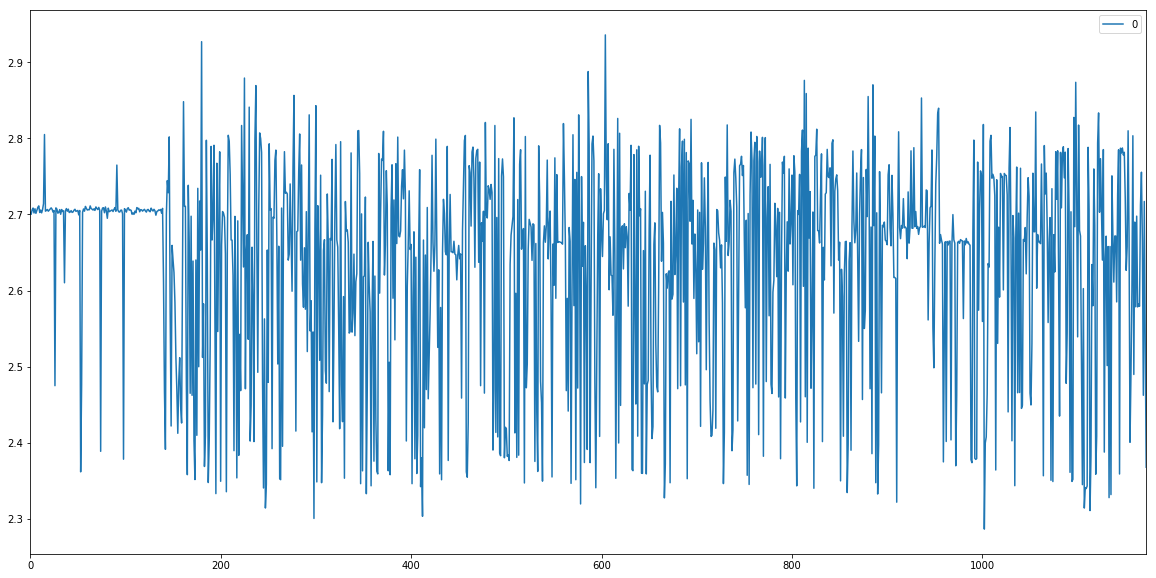

In [0]:
pd.DataFrame(predictions).plot(figsize=(20, 10))